In [2]:
from dataclasses import dataclass

import numpy as np
import networkx as nx

import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from tensordict import TensorDict

from castle.datasets import DAG, IIDSimulation 
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

import causica.distributions as cd

from causica.functional_relationships import ICGNN
from causica.training.auglag import AugLagLossCalculator, AugLagLR, AugLagLRConfig
from causica.graph.dag_constraint import calculate_dagness

from causica.datasets.variable_types import VariableTypeEnum
from causica.datasets.tensordict_utils import tensordict_shapes

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from dowhy import gcm
import pandas as pd

In [3]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Set random seed
SEED = 11
np.random.seed(SEED)
pl.seed_everything(SEED)  

Global seed set to 11


In [5]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])

In [6]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

# adj_matrix=causal_graph

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [7]:
#Treat dataset

#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['identifier', 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

X = consolidated.to_numpy()
print(X)

[[8.00000000e+00 6.00000000e+00 1.20000000e+01 4.00000000e+00
  8.00000000e+00 2.00000000e+00 2.50000000e-01 1.00000000e+00
  2.14921603e+03 1.26208150e+06 1.83048956e+03 1.68197700e+06
  1.53700000e+03 1.25000000e+02 1.70000000e+01 1.09756000e+05
  0.00000000e+00]
 [8.00000000e+00 6.00000000e+00 1.20000000e+01 4.00000000e+00
  8.00000000e+00 2.00000000e+00 2.50000000e-01 3.00000000e+00
  2.16013311e+03 1.22045800e+06 1.60616964e+03 1.84350400e+06
  2.13700000e+03 0.00000000e+00 1.00000000e+00 4.86800000e+03
  0.00000000e+00]
 [1.60000000e+01 8.00000000e+00 2.00000000e+01 1.60000000e+01
  8.00000000e+00 4.00000000e+00 5.00000000e-01 1.00000000e+00
  2.00863670e+03 9.91947500e+05 1.29975518e+03 1.42825400e+06
  2.13800000e+03 0.00000000e+00 0.00000000e+00 7.92000000e+02
  0.00000000e+00]
 [1.60000000e+01 8.00000000e+00 2.00000000e+01 1.60000000e+01
  8.00000000e+00 4.00000000e+00 5.00000000e-01 5.00000000e-01
  6.67495367e+03 3.88920000e+05 6.21536311e+02 7.62906000e+05
  1.38700000e+03

In [8]:
@dataclass(frozen=True)
class TrainingConfig:
 noise_dist=cd.ContinuousNoiseDist.SPLINE
 batch_size=512
 max_epoch=500
 gumbel_temp=0.25
 averaging_period=10
 prior_sparsity_lambda=5.0
 init_rho=1.0
 init_alpha=0.0
training_config = TrainingConfig()
auglag_config = AugLagLRConfig()

In [9]:
# Cast data to torch tensors
data_tensors = {}

for i in range(X.shape[1]):
    data_tensors[f'x{i}'] = torch.tensor(X[:, i].reshape(-1, 1))
    
dataset_train = TensorDict(data_tensors, torch.Size([X.shape[0]]))
    
# Move the entire dataset to the device (for big datasets move to device by batch within training loop)
dataset_train = dataset_train.apply(lambda t: t.to(dtype=torch.float32, device=device))

# Create loader
dataloader_train = DataLoader(
    dataset=dataset_train,
    collate_fn=lambda x: x,
    batch_size=training_config.batch_size,
    shuffle=True,
    drop_last=False,
)

dataset_train

TensorDict(
    fields={
        x0: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x10: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x11: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x12: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x13: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x14: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x15: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x16: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x1: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        x2: Tensor(shape=torch.Size([28, 1]), device=cpu, dtype=torch.float32, is_shared=False)

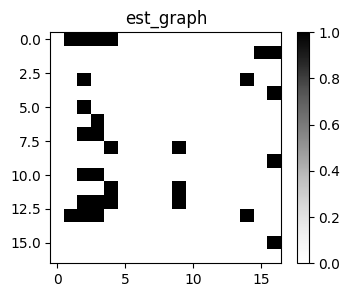

In [10]:
# Plot the true adj matrix
plt.style.use('default')
GraphDAG(true_causal_matrix)
plt.show()

In [11]:
# Encode our strong belief about the existence of the edge (3, 0) 
# And lack of existence of edge (0, 3)
adj_matrix = true_causal_matrix
expert_matrix = torch.tensor(np.zeros(adj_matrix.shape))

# Encode the edge knowledge
expert_matrix[3, 0] = 1.

# Create a relevancew mask
relevance_mask = expert_matrix.clone()
relevance_mask[0, 3] = 1.

# Create a confidence matrix
confidence_matrix = relevance_mask.clone()

In [12]:
# Encapsulate everything within the expert knowledge container
expert_knowledge = cd.ExpertGraphContainer(
    dag=expert_matrix,
    mask=relevance_mask,
    confidence=confidence_matrix,
    scale=5.
)

In [13]:
num_nodes = len(dataset_train.keys())

# Define the prior
prior = cd.GibbsDAGPrior(
    num_nodes=num_nodes, 
    sparsity_lambda=training_config.prior_sparsity_lambda,
    expert_graph_container=expert_knowledge
)

In [14]:
# Define the adjaceny module
adjacency_dist = cd.ENCOAdjacencyDistributionModule(num_nodes)

#Define the functional module
icgnn = ICGNN(
    variables=tensordict_shapes(dataset_train),
    embedding_size=8, #32,
    out_dim_g=8, #32,
    norm_layer=torch.nn.LayerNorm,
    res_connection=True,
)

# Define the noise module
types_dict = {var_name: VariableTypeEnum.CONTINUOUS for var_name in dataset_train.keys()}

noise_submodules = cd.create_noise_modules(
    shapes=tensordict_shapes(dataset_train), 
    types=types_dict, 
    continuous_noise_dist=training_config.noise_dist
)

noise_module = cd.JointNoiseModule(noise_submodules)

In [15]:
noise_submodules

{'x0': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x1': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x2': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x3': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x4': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x5': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x6': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x7': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
     (0-1): 2 x CompositeSplineLayer()
   )
 ),
 'x8': SplineNoiseModule(
   (composite_spline_layers): ModuleList(
    

In [16]:
?cd.SEMDistributionModule

Init signature:
cd.SEMDistributionModule(
    adjacency_module: causica.distributions.distribution_module.DistributionModule[causica.distributions.adjacency.adjacency_distributions.AdjacencyDistribution],
    functional_relationships: causica.functional_relationships.functional_relationships.FunctionalRelationships,
    noise_module: causica.distributions.noise.joint.JointNoiseModule,
)
Docstring:      Represents a SEMDistribution with learnable parameters.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           ~/anaconda3/envs/py10/lib/python3.10/site-packages/causica/distributions/sem_distribution.py
Type:           type
Subclasses:     

In [17]:
# Combine all SEM modules
sem_module = cd.SEMDistributionModule(
    adjacency_module=adjacency_dist, 
    functional_relationships=icgnn, 
    noise_module=noise_module)

sem_module.to(device)

SEMDistributionModule(
  (adjacency_module): ENCOAdjacencyDistributionModule()
  (functional_relationships): ICGNN(
    (nn): FGNNI(
      (g): Sequential(
        (0): Sequential(
          (0): Linear(in_features=25, out_features=68, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=68, out_features=68, bias=True)
            (2): LeakyReLU(negative_slope=0.01)
          )
        )
        (2): LayerNorm((68,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=68, out_features=8, bias=True)
        (4): Identity()
      )
      (f): Sequential(
        (0): Sequential(
          (0): Linear(in_features=16, out_features=68, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
        )
        (1): _ResBlock(
          (block): Sequential(
            (0): LayerNorm((68,), eps=1e-05, ele

In [18]:
modules = {
    "icgnn": sem_module.functional_relationships,
    "vardist": sem_module.adjacency_module,
    "noise_dist": sem_module.noise_module,
}

parameter_list = [
    {"params": module.parameters(), "lr": auglag_config.lr_init_dict[name], "name": name}
    for name, module in modules.items()
]

# Define the optimizer
optimizer = torch.optim.Adam(parameter_list)

In [19]:
# Define the augmented Lagrangian loss objects
scheduler = AugLagLR(config=auglag_config)

auglag_loss = AugLagLossCalculator(
    init_alpha=training_config.init_alpha, 
    init_rho=training_config.init_rho
)

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:0 loss:1.3849e+12 nll:1.3849e+12 dagness:32.17364 num_edges:64 alpha:0 rho:1 step:0|1 num_lr_updates:0


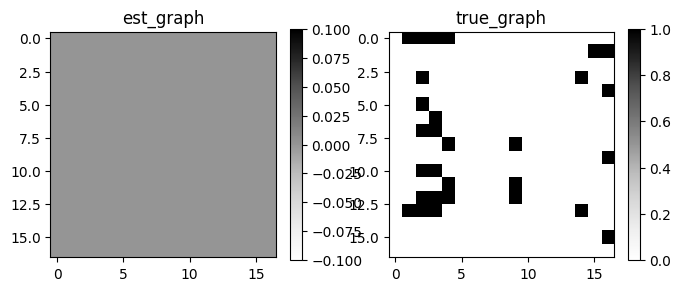

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:10 loss:1.2289e+12 nll:1.2289e+12 dagness:20.29732 num_edges:61 alpha:0 rho:1 step:0|11 num_lr_updates:0


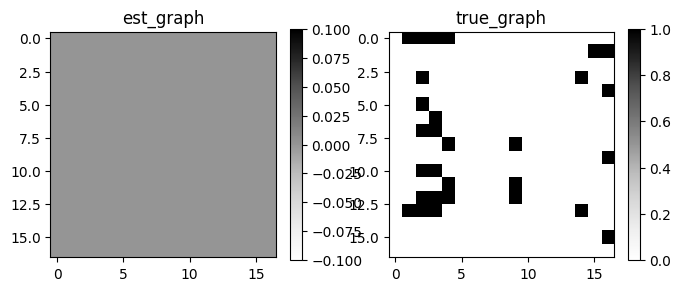

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:20 loss:1.0933e+12 nll:1.0933e+12 dagness:34.48385 num_edges:65 alpha:0 rho:1 step:0|21 num_lr_updates:0


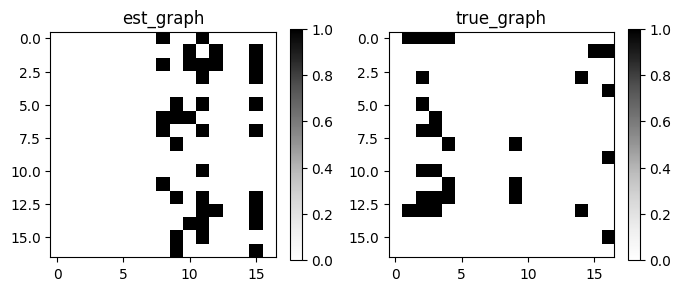

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:30 loss:9.7697e+11 nll:9.7697e+11 dagness:28.44807 num_edges:69 alpha:0 rho:1 step:0|31 num_lr_updates:0


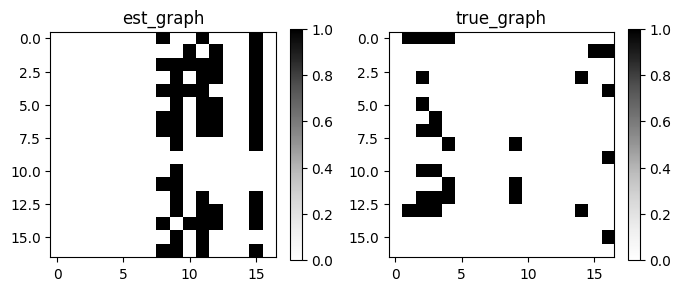

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:40 loss:8.7773e+11 nll:8.7773e+11 dagness:31.81573 num_edges:80 alpha:0 rho:1 step:0|41 num_lr_updates:0


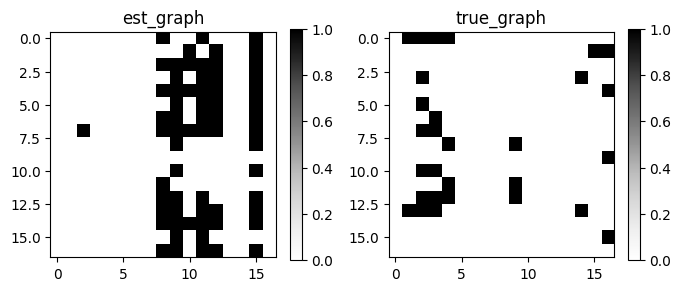

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:50 loss:7.9304e+11 nll:7.9304e+11 dagness:13.50420 num_edges:73 alpha:0 rho:1 step:0|51 num_lr_updates:0


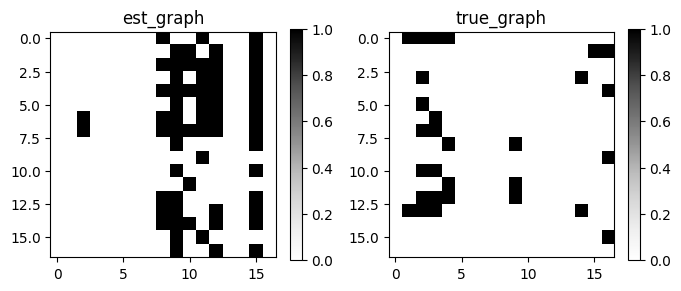

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:60 loss:7.2048e+11 nll:7.2048e+11 dagness:13.97217 num_edges:76 alpha:0 rho:1 step:0|61 num_lr_updates:0


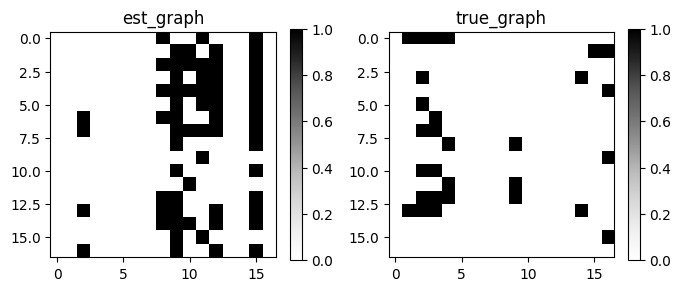

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:70 loss:6.579e+11 nll:6.579e+11 dagness:24.69435 num_edges:79 alpha:0 rho:1 step:0|71 num_lr_updates:0


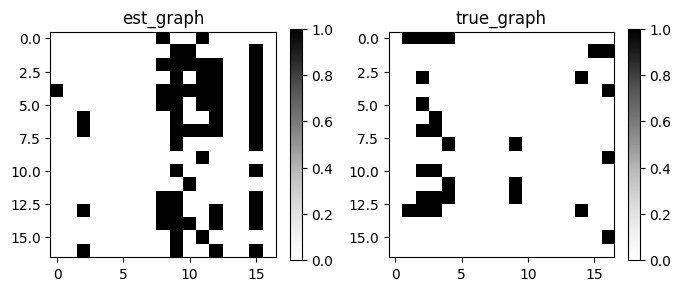

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:80 loss:6.0358e+11 nll:6.0358e+11 dagness:19.10564 num_edges:75 alpha:0 rho:1 step:0|81 num_lr_updates:0


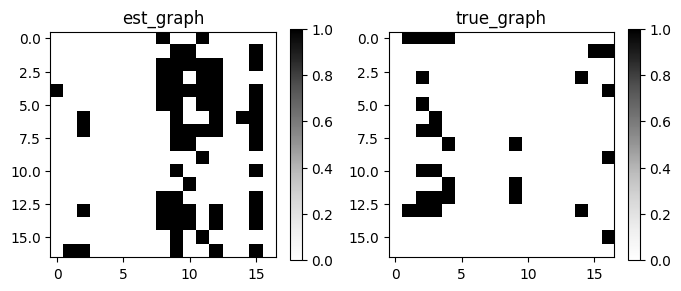

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:90 loss:5.5609e+11 nll:5.5609e+11 dagness:10.66013 num_edges:83 alpha:0 rho:1 step:0|91 num_lr_updates:0


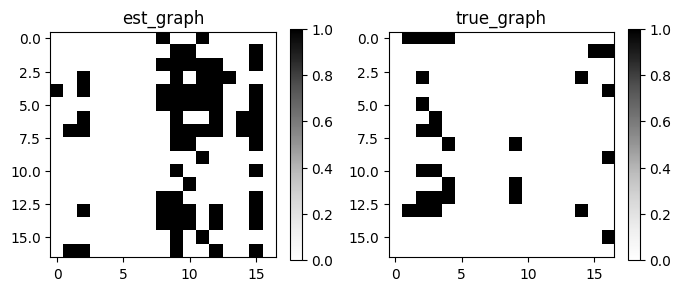

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:100 loss:5.1432e+11 nll:5.1432e+11 dagness:18.50859 num_edges:79 alpha:0 rho:1 step:0|101 num_lr_updates:0


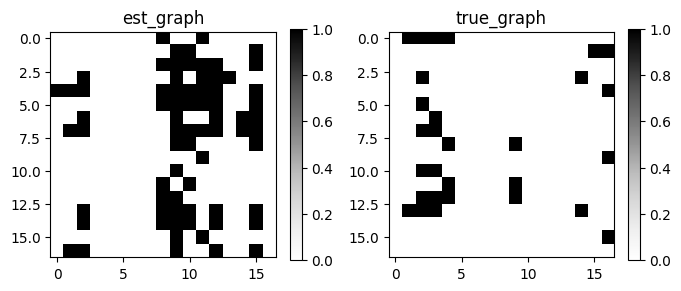

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:110 loss:4.7736e+11 nll:4.7736e+11 dagness:14.75319 num_edges:78 alpha:0 rho:1 step:0|111 num_lr_updates:0


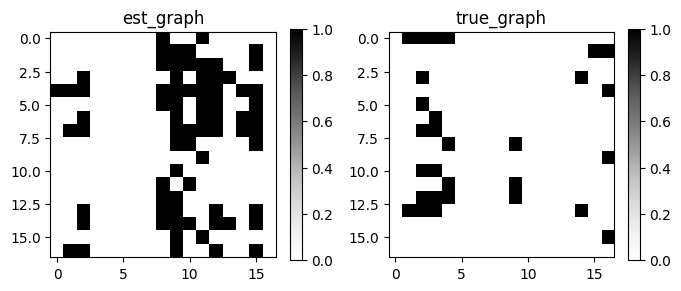

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:120 loss:4.4448e+11 nll:4.4448e+11 dagness:13.85992 num_edges:83 alpha:0 rho:1 step:0|121 num_lr_updates:0


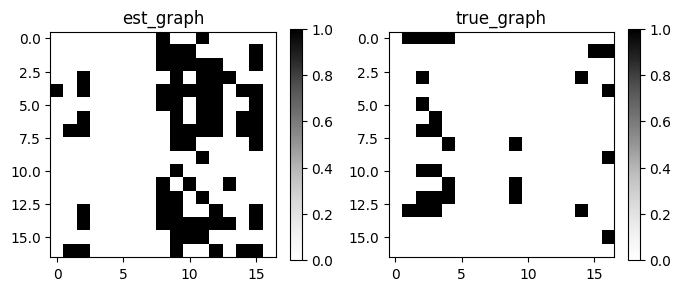

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:130 loss:4.1509e+11 nll:4.1509e+11 dagness:10.52999 num_edges:84 alpha:0 rho:1 step:0|131 num_lr_updates:0


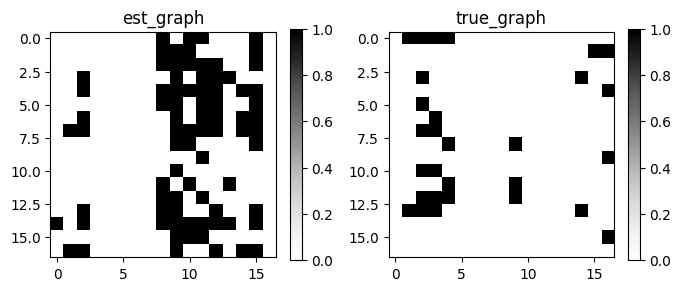

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:140 loss:3.8868e+11 nll:3.8868e+11 dagness:14.01023 num_edges:80 alpha:0 rho:1 step:0|141 num_lr_updates:0


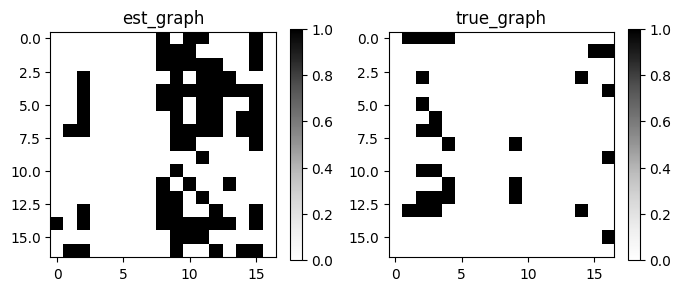

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:150 loss:3.6487e+11 nll:3.6487e+11 dagness:11.21124 num_edges:86 alpha:0 rho:1 step:0|151 num_lr_updates:0


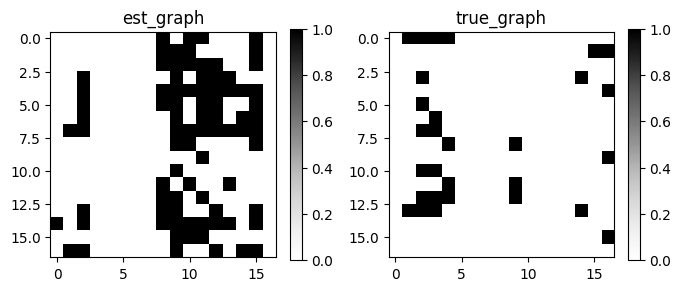

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:160 loss:3.4331e+11 nll:3.4331e+11 dagness:15.92900 num_edges:90 alpha:0 rho:1 step:0|161 num_lr_updates:0


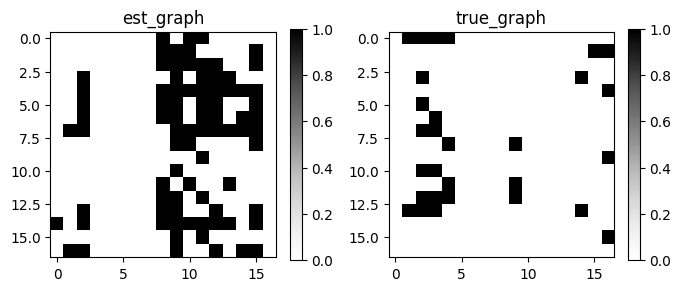

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:170 loss:3.2371e+11 nll:3.2371e+11 dagness:10.27127 num_edges:91 alpha:0 rho:1 step:0|171 num_lr_updates:0


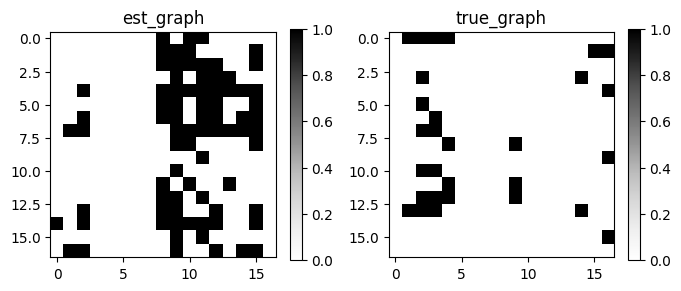

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:180 loss:3.0585e+11 nll:3.0585e+11 dagness:1.85862 num_edges:76 alpha:0 rho:1 step:0|181 num_lr_updates:0


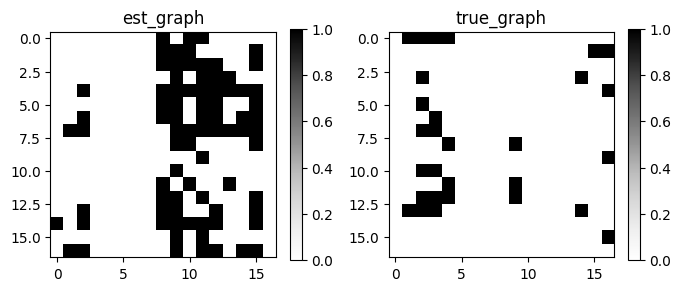

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:190 loss:2.8951e+11 nll:2.8951e+11 dagness:4.50124 num_edges:74 alpha:0 rho:1 step:0|191 num_lr_updates:0


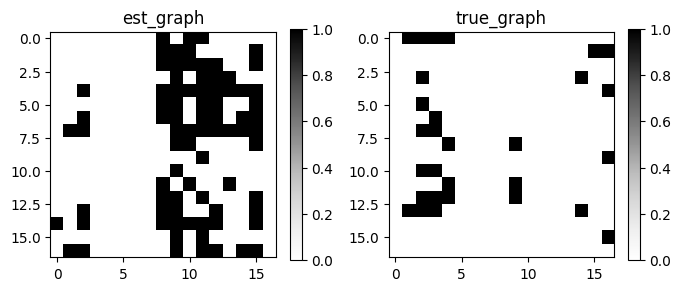

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:200 loss:2.7452e+11 nll:2.7452e+11 dagness:6.46823 num_edges:94 alpha:0 rho:1 step:0|201 num_lr_updates:0


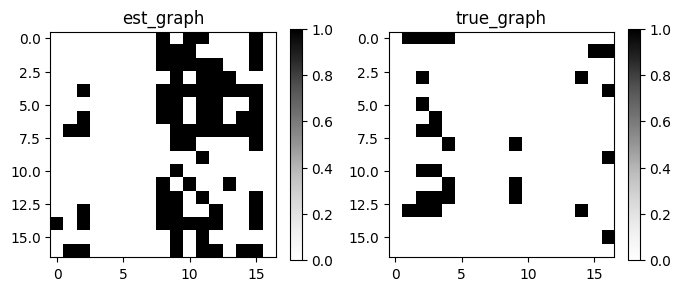

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:210 loss:2.6074e+11 nll:2.6074e+11 dagness:55.65553 num_edges:91 alpha:0 rho:1 step:0|211 num_lr_updates:0


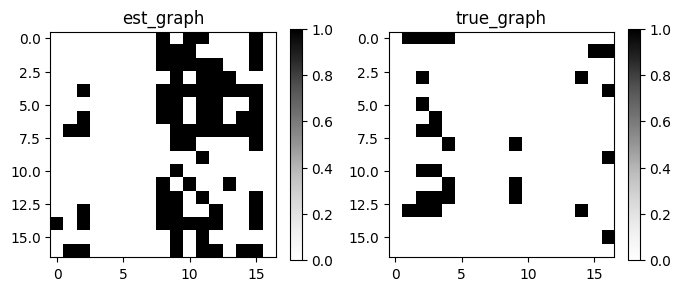

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:220 loss:2.4802e+11 nll:2.4802e+11 dagness:5.05268 num_edges:82 alpha:0 rho:1 step:0|221 num_lr_updates:0


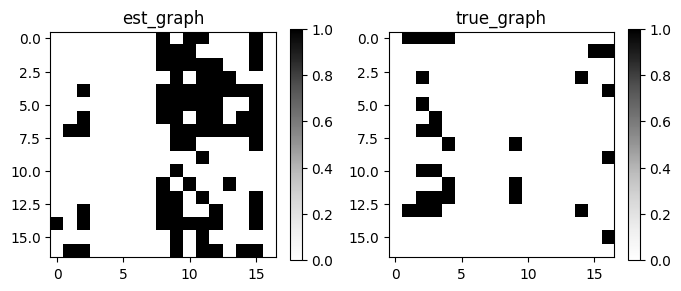

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:230 loss:2.3627e+11 nll:2.3627e+11 dagness:4.44179 num_edges:81 alpha:0 rho:1 step:0|231 num_lr_updates:0


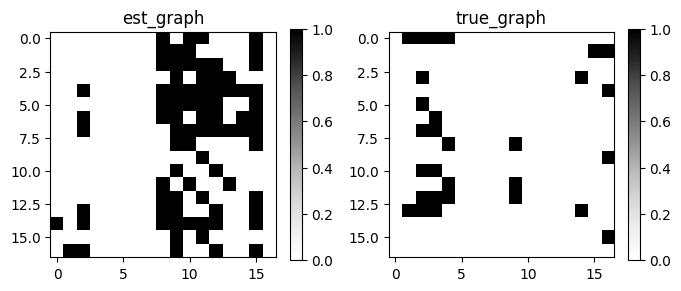

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:240 loss:2.2539e+11 nll:2.2539e+11 dagness:19.57909 num_edges:90 alpha:0 rho:1 step:0|241 num_lr_updates:0


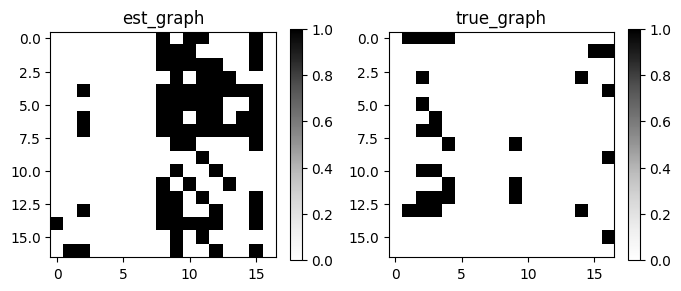

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:250 loss:2.1528e+11 nll:2.1528e+11 dagness:4.21124 num_edges:89 alpha:0 rho:1 step:0|251 num_lr_updates:0


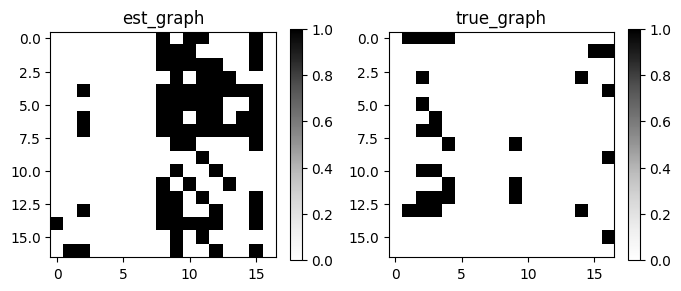

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:260 loss:2.0587e+11 nll:2.0587e+11 dagness:24.92682 num_edges:89 alpha:0 rho:1 step:0|261 num_lr_updates:0


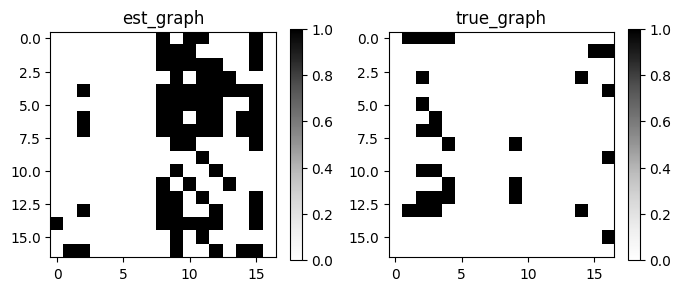

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:270 loss:1.9711e+11 nll:1.9711e+11 dagness:7.67093 num_edges:84 alpha:0 rho:1 step:0|271 num_lr_updates:0


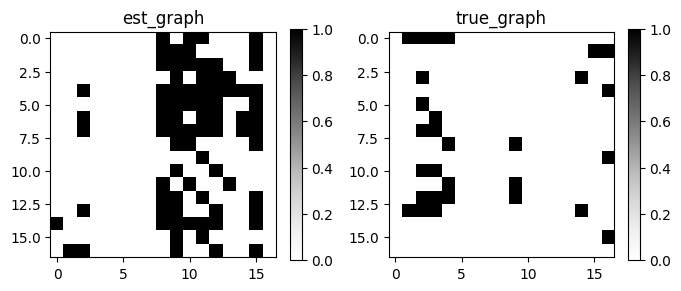

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:280 loss:1.8892e+11 nll:1.8892e+11 dagness:18.85690 num_edges:93 alpha:0 rho:1 step:0|281 num_lr_updates:0


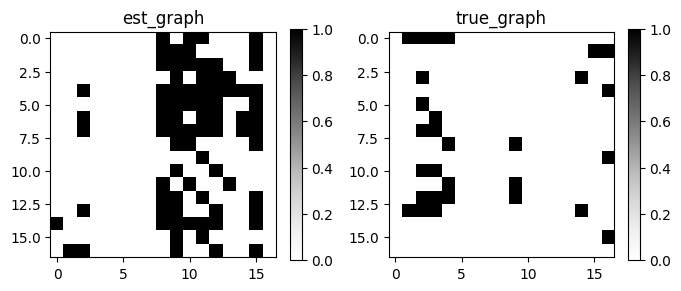

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:290 loss:1.8127e+11 nll:1.8127e+11 dagness:14.72616 num_edges:87 alpha:0 rho:1 step:0|291 num_lr_updates:0


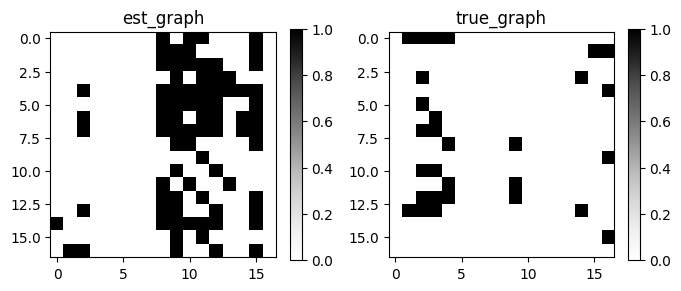

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:300 loss:1.7409e+11 nll:1.7409e+11 dagness:23.58426 num_edges:95 alpha:0 rho:1 step:0|301 num_lr_updates:0


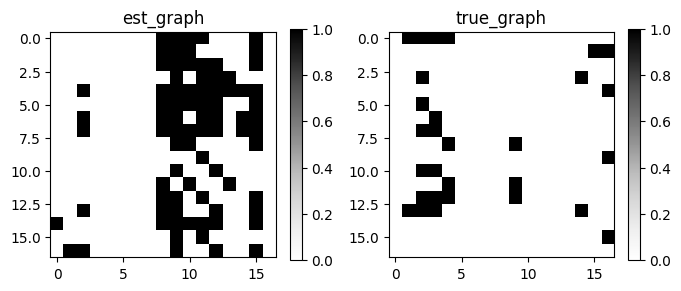

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:310 loss:1.6736e+11 nll:1.6736e+11 dagness:9.56527 num_edges:82 alpha:0 rho:1 step:0|311 num_lr_updates:0


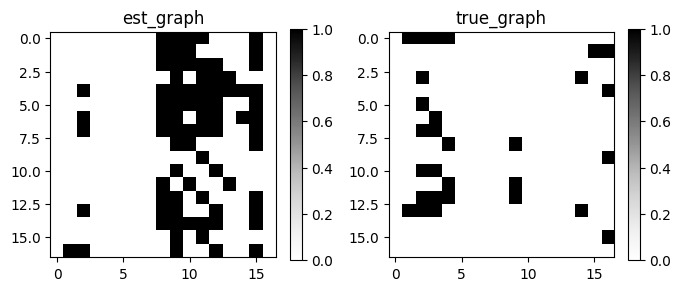

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:320 loss:1.6103e+11 nll:1.6103e+11 dagness:6.82764 num_edges:81 alpha:0 rho:1 step:0|321 num_lr_updates:0


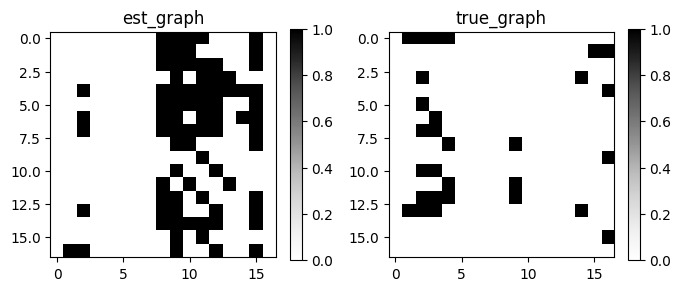

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:330 loss:1.5507e+11 nll:1.5507e+11 dagness:11.40028 num_edges:87 alpha:0 rho:1 step:0|331 num_lr_updates:0


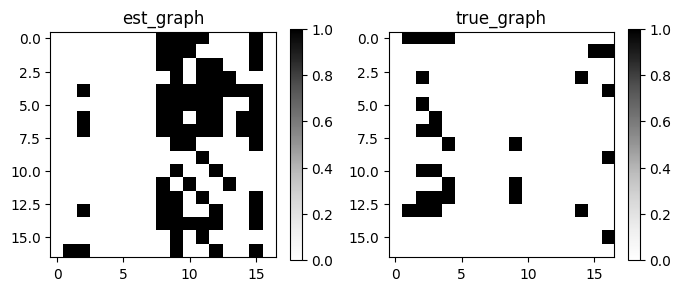

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:340 loss:1.4946e+11 nll:1.4946e+11 dagness:17.42357 num_edges:85 alpha:0 rho:1 step:0|341 num_lr_updates:0


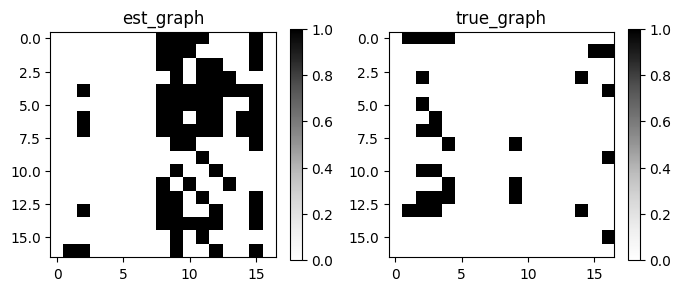

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:350 loss:1.4416e+11 nll:1.4416e+11 dagness:14.84847 num_edges:90 alpha:0 rho:1 step:0|351 num_lr_updates:0


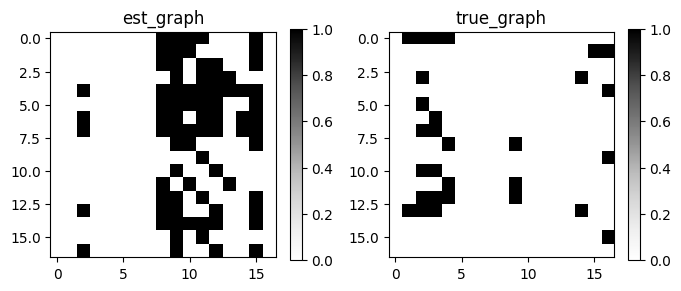

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:360 loss:1.3916e+11 nll:1.3916e+11 dagness:4.54775 num_edges:83 alpha:0 rho:1 step:0|361 num_lr_updates:0


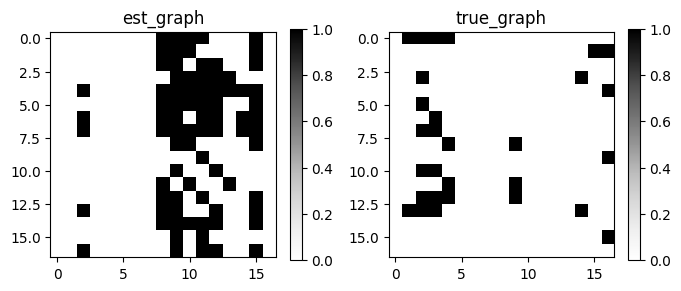

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:370 loss:1.3442e+11 nll:1.3442e+11 dagness:10.58308 num_edges:88 alpha:0 rho:1 step:0|371 num_lr_updates:0


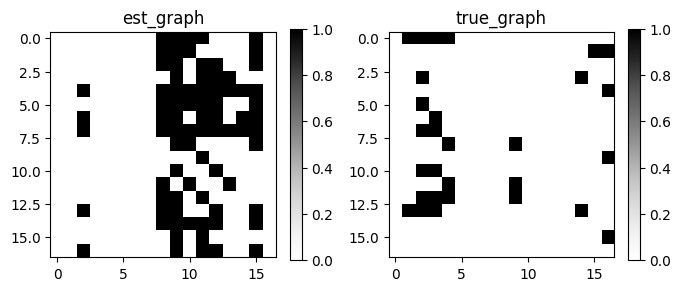

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:380 loss:1.2993e+11 nll:1.2993e+11 dagness:11.31833 num_edges:79 alpha:0 rho:1 step:0|381 num_lr_updates:0


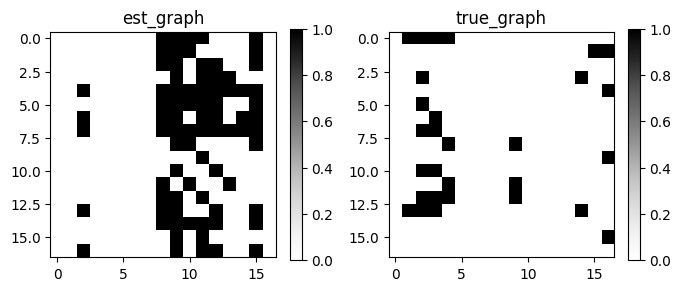

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:390 loss:1.2568e+11 nll:1.2568e+11 dagness:7.72632 num_edges:84 alpha:0 rho:1 step:0|391 num_lr_updates:0


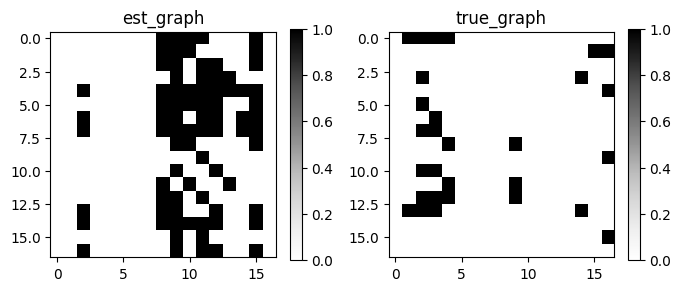

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:400 loss:1.2165e+11 nll:1.2165e+11 dagness:19.39423 num_edges:89 alpha:0 rho:1 step:0|401 num_lr_updates:0


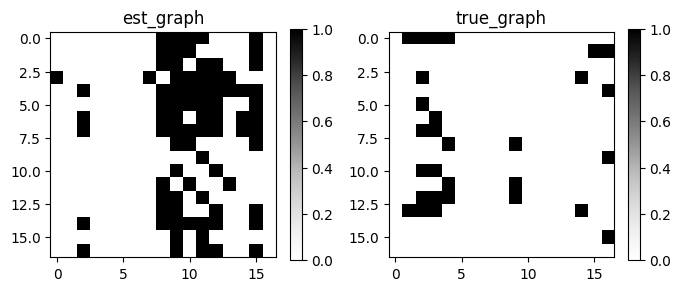

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:410 loss:1.1781e+11 nll:1.1781e+11 dagness:28.17926 num_edges:96 alpha:0 rho:1 step:0|411 num_lr_updates:0


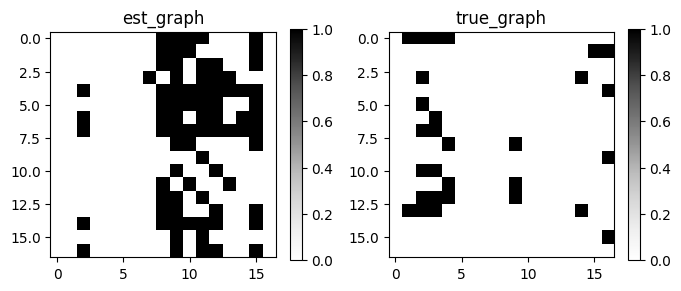

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:420 loss:1.1416e+11 nll:1.1416e+11 dagness:14.33201 num_edges:89 alpha:0 rho:1 step:0|421 num_lr_updates:0


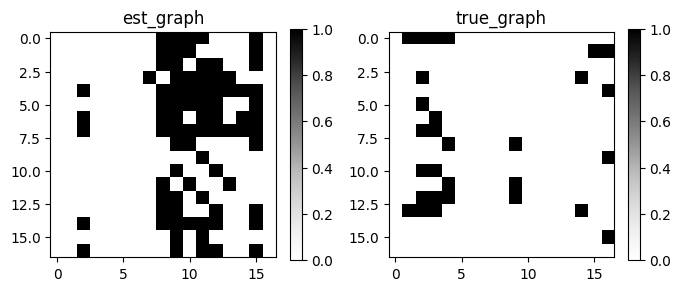

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:430 loss:1.1069e+11 nll:1.1069e+11 dagness:8.45381 num_edges:83 alpha:0 rho:1 step:0|431 num_lr_updates:0


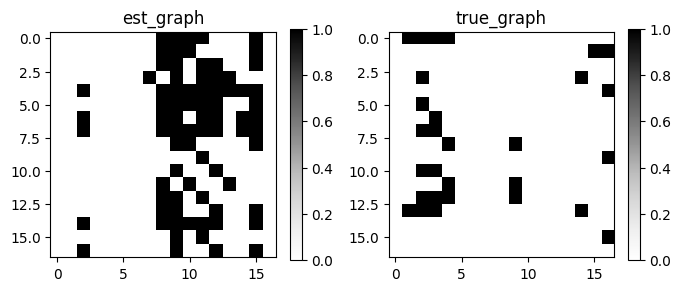

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:440 loss:1.0738e+11 nll:1.0738e+11 dagness:6.03572 num_edges:78 alpha:0 rho:1 step:0|441 num_lr_updates:0


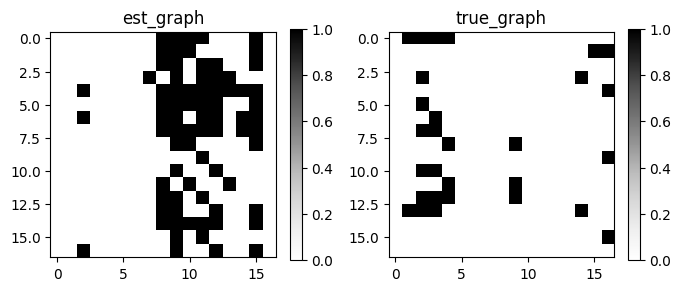

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:450 loss:1.0423e+11 nll:1.0423e+11 dagness:3.51068 num_edges:80 alpha:0 rho:1 step:0|451 num_lr_updates:0


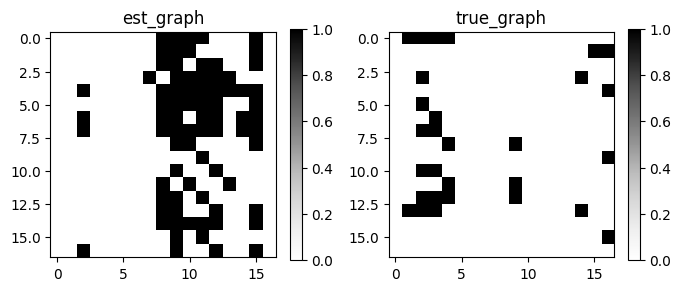

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:460 loss:1.0122e+11 nll:1.0122e+11 dagness:3.70706 num_edges:79 alpha:0 rho:1 step:0|461 num_lr_updates:0


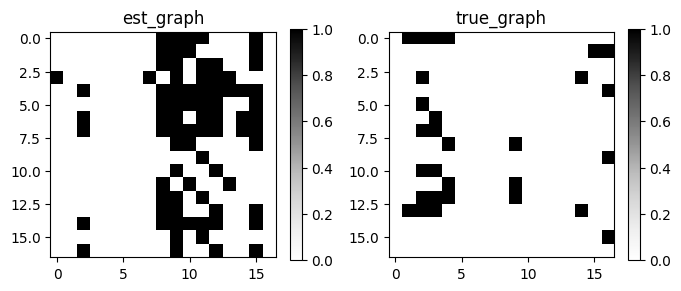

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:470 loss:9.8343e+10 nll:9.8343e+10 dagness:9.64944 num_edges:87 alpha:0 rho:1 step:0|471 num_lr_updates:0


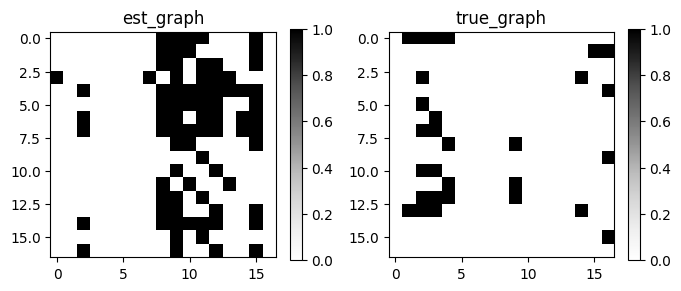

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:480 loss:9.5593e+10 nll:9.5593e+10 dagness:5.70877 num_edges:79 alpha:0 rho:1 step:0|481 num_lr_updates:0


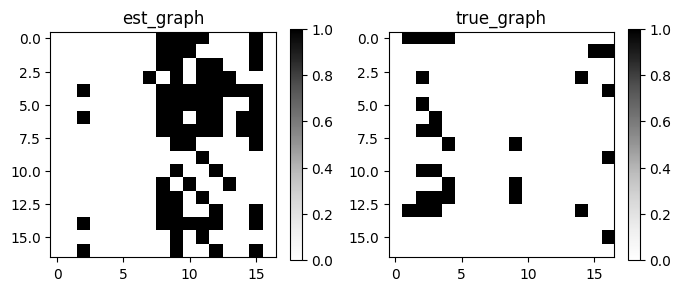

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


epoch:490 loss:9.2963e+10 nll:9.2963e+10 dagness:6.15306 num_edges:80 alpha:0 rho:1 step:0|491 num_lr_updates:0


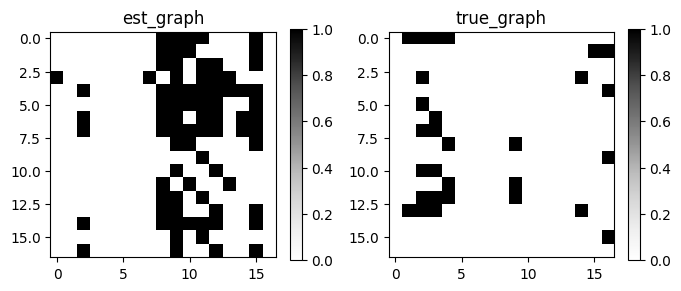

/home/flav/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'causica.distributions.noise.joint.JointNoise'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [20]:
assert len(dataset_train.batch_size) == 1, "Only 1D batch size is supported"

num_samples = len(dataset_train)

for epoch in range(training_config.max_epoch):
    
    for i, batch in enumerate(dataloader_train):
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Get SEM 
        sem_distribution = sem_module()
        sem, *_ = sem_distribution.relaxed_sample(
            torch.Size([]), 
            temperature=training_config.gumbel_temp
        )  # soft sample
        
        # Compute the log probability of data
        batch_log_prob = sem.log_prob(batch).mean()
        
        # Get the distribution entropy
        sem_distribution_entropy = sem_distribution.entropy()
        
        # Compute the likelihood of the current graph
        prior_term = prior.log_prob(sem.graph)
        
        # Compute the objective
        objective = (-sem_distribution_entropy - prior_term) / num_samples - batch_log_prob
        
        # Compute the DAG-ness term
        constraint = calculate_dagness(sem.graph)
        
        # Compute the Lagrangian loss
        loss = auglag_loss(objective, constraint / num_samples)

        # Propagate gradients and update
        loss.backward()
        optimizer.step()
        
        # Update the Auglag parameters
        scheduler.step(
            optimizer=optimizer,
            loss=auglag_loss,
            loss_value=loss.item(),
            lagrangian_penalty=constraint.item(),
        )
        
        # Log metrics & plot the matrices
        if epoch % 10 == 0 and i == 0:
            print(
                f"epoch:{epoch} loss:{loss.item():.5g} nll:{-batch_log_prob.detach().cpu().numpy():.5g} "
                f"dagness:{constraint.item():.5f} num_edges:{(sem.graph > 0.0).sum()} "
                f"alpha:{auglag_loss.alpha:.5g} rho:{auglag_loss.rho:.5g} "
                f"step:{scheduler.outer_opt_counter}|{scheduler.step_counter} "
                f"num_lr_updates:{scheduler.num_lr_updates}"
            )
            
            vardist = adjacency_dist()
            pred_dag = vardist.mode.cpu().numpy()

            plt.style.use('default')

            GraphDAG(
                est_dag=pred_dag, 
                true_dag=adj_matrix)

            plt.show()

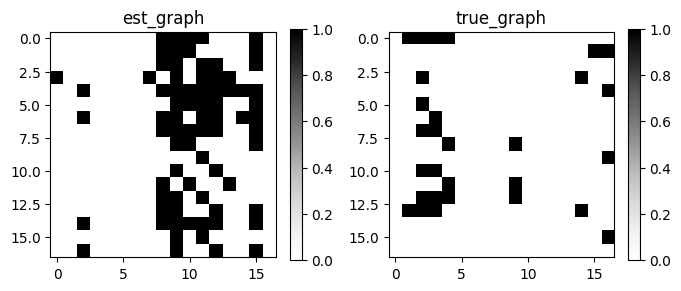

In [21]:
# Sample from the distribution of graphs
vardist = adjacency_dist()
pred_dag = vardist.mode.cpu().numpy()


# Plot the final graph vs the ground truth
plt.style.use('default')

GraphDAG(
    est_dag=pred_dag, 
    true_dag=adj_matrix)

plt.show()

In [22]:
# Compute and print the metrics
metrics = MetricsDAG(
    B_est=pred_dag, 
    B_true=adj_matrix)

metrics.metrics

{'fdr': 0.9605,
 'tpr': 0.1034,
 'fpr': 0.6822,
 'shd': 88,
 'nnz': 76,
 'precision': 0.0395,
 'recall': 0.1034,
 'F1': 0.0571,
 'gscore': 0.0}

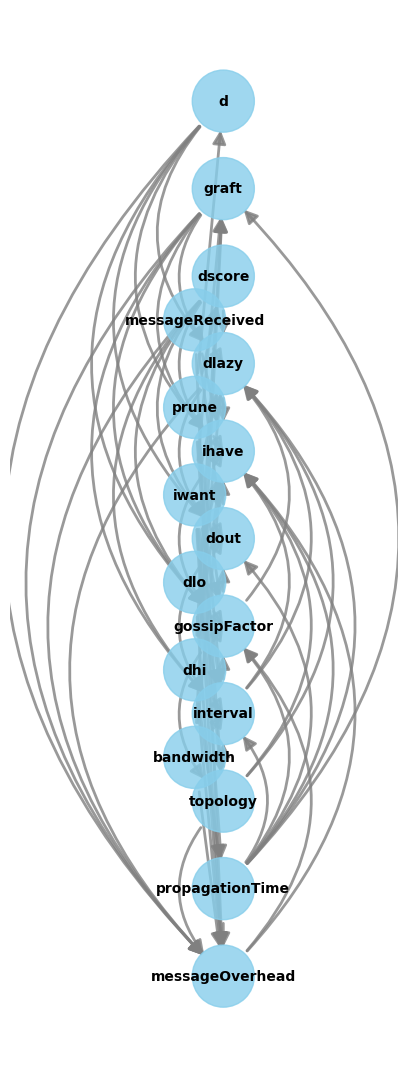

In [29]:
learned_causal_graph =  nx.from_numpy_array(pred_dag, create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

# fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])